<a href="https://colab.research.google.com/github/GMobinit/cat_dog_recognition_model/blob/VGG_model/cat_dog_recognition_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! wget https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip

--2025-11-01 15:42:20--  https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.48.229.170, 2600:140e:6:3aa::317f, 2600:140e:6:3be::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.48.229.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip.1’

kagglecatsanddogs_5 100%[===================>] 786.67M   127MB/s    in 9.9s    

2025-11-01 15:42:30 (79.7 MB/s) - ‘kagglecatsanddogs_5340.zip.1’ saved [824887076/824887076]



In [1]:
import tensorflow as tf
import zipfile
tf.__version__

'2.19.0'

In [2]:
zipfile.ZipFile('kagglecatsanddogs_5340.zip', 'r').extractall('dataset')

In [3]:
import pathlib
data_dir = pathlib.Path('dataset/PetImages').with_suffix('')

In [4]:
cat_image_count = len(list(data_dir.glob('Cat/*.jpg')))
dog_image_count = len(list(data_dir.glob('Dog/*.jpg')))
print(f"cat image count: {cat_image_count}, dog image count: {dog_image_count}, all images: {cat_image_count+dog_image_count}")

cat image count: 12500, dog image count: 12500, all images: 25000


In [5]:
# import PIL

In [6]:
# PIL.Image.open(str(list(data_dir.glob('Cat/910.jpg'))[0]))

In [7]:
list_ds  = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'), shuffle=False)
list_ds = list_ds.shuffle(cat_image_count+dog_image_count, reshuffle_each_iteration=False)
print(len(list_ds))

25000


In [8]:
for file_add in list_ds.take(5):
  print(file_add)

tf.Tensor(b'dataset/PetImages/Cat/12290.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/PetImages/Dog/4176.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/PetImages/Cat/6239.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/PetImages/Dog/2798.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/PetImages/Dog/4174.jpg', shape=(), dtype=string)


In [9]:
labels = []
for item in data_dir.glob('*'):
  labels.append(item.name)

print(labels)

['Dog', 'Cat']


In [10]:
## train validation split
validation_percentage = 0.2
validation_size = int((cat_image_count+dog_image_count)*validation_percentage)
print(validation_size)
print(len(list_ds))
validation_ds = list_ds.take(validation_size)
train_ds = list_ds.skip(validation_size)

print(f'validation size {len(validation_ds)}, train size {len(train_ds)}')

5000
25000
validation size 5000, train size 20000


In [11]:
import os
def get_label(file_path):
  separated_path = tf.strings.split(file_path, os.path.sep)
  label = separated_path[-2]
  one_hotted_label = (label == labels)
  return tf.argmax(one_hotted_label)

In [12]:
get_label('dataset/kagglecatsanddogs_3367a/PetImages/Cat/7411.jpg')

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [13]:
batch_size = 32
img_height = 180
img_width = 180

In [14]:
def decode_img(encoded_img):
  img = tf.io.decode_jpeg(encoded_img, channels=3)
  img = tf.image.resize(img, [img_height, img_width], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return img

In [15]:
def process_path(img_path):
  label = get_label(img_path)
  img = tf.io.read_file(img_path)
  if tf.equal(tf.strings.length(img), 0):
    print("warning: empty file at ", img)
  try:
    img = decode_img(img)
  except Exception as e:
    print(f"wrong image format {img_path}")
  print(img)
  img = tf.cast(img, tf.float32)
  # img = ((img/255))
  return img, label

In [16]:
import os

def is_valid_image(img_path):
    img = tf.io.read_file(img_path)
    # Check if the file can be decoded as a JPEG image
    is_jpeg = tf.image.is_jpeg(img)
    return is_jpeg

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

# Filter out images that cause decoding errors
# def is_valid_image(img_path):
#   img = tf.io.read_file(img_path)
#   if tf.not_equal(tf.strings.length(img), 0):
#     try:
#       decoded_img = tf.io.decode_jpeg(img, channels=3)
#       # Check if the image has 3 channels (RGB)
#       return tf.equal(tf.shape(decoded_img)[-1], 3)
#     except Exception as e:
#       # Catching exceptions within tf.data.Dataset.filter is not ideal for performance
#       # but is used here for debugging purposes to identify problematic files.
#       # In a production pipeline, it's better to handle this differently, e.g.,
#       # by using tf.debugging.assert_equal and then filtering based on the assertion.
#       tf.print(f"Invalid image: {img_path}")
#       return False
#   else:
#     tf.print(f"Empty image: {img_path}")
#     return False

filtered_train_ds = train_ds.filter(is_valid_image)
filtered_validation_ds = validation_ds.filter(is_valid_image)

# Count the elements in the filtered datasets
train_count = 0
for _ in filtered_train_ds:
  train_count += 1

validation_count = 0
for _ in filtered_validation_ds:
  validation_count += 1


mapped_train_ds = filtered_train_ds.map(map_func= process_path,num_parallel_calls=AUTOTUNE)
mapped_validation_ds = filtered_validation_ds.map(map_func=process_path, num_parallel_calls=AUTOTUNE)

# Add checks to see the size of the datasets after filtering
print(f"Size of filtered_train_ds after filtering: {train_count}")
print(f"Size of filtered_validation_ds after filtering: {validation_count}")
print(f"Size of all filtered data: {validation_count+train_count}")
print(f"Size of mapped_train_ds after filtering: {tf.data.experimental.cardinality(mapped_train_ds).numpy()}")
print(f"Size of mapped_validation_ds after filtering: {tf.data.experimental.cardinality(mapped_validation_ds).numpy()}")

Tensor("resize/Squeeze:0", shape=(180, 180, 3), dtype=uint8)
Tensor("resize/Squeeze:0", shape=(180, 180, 3), dtype=uint8)
Size of filtered_train_ds after filtering: 19811
Size of filtered_validation_ds after filtering: 4958
Size of all filtered data: 24769
Size of mapped_train_ds after filtering: -2
Size of mapped_validation_ds after filtering: -2


In [18]:
# for item in mapped_train_ds.take(5):
#   print("Image shape: ", item)

In [19]:
def configure_for_performance(ds: tf.data.Dataset):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=500)
  ds = ds.batch(batch_size, drop_remainder=True)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [20]:
high_performance_train_ds = configure_for_performance(mapped_train_ds)

# train_count = 0
# for _ in high_performance_train_ds:
#   train_count += 1
# print(f"Size of high_performance_train_ds: {train_count}")

high_performance_validation_ds = configure_for_performance(mapped_validation_ds)

validation_count = 0
for _ in high_performance_validation_ds:
  validation_count += 1
print(f"Size of high_performance_validation_ds: {validation_count}")

Size of high_performance_validation_ds: 154


In [21]:
for a,b in high_performance_train_ds.take(619):
  print(a.shape)
  print(b.numpy())

(32, 180, 180, 3)
[1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1]
(32, 180, 180, 3)
[1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0]
(32, 180, 180, 3)
[0 0 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1]
(32, 180, 180, 3)
[1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1]
(32, 180, 180, 3)
[1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0]
(32, 180, 180, 3)
[1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0]
(32, 180, 180, 3)
[1 0 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 1]
(32, 180, 180, 3)
[0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1]
(32, 180, 180, 3)
[0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 0 0]
(32, 180, 180, 3)
[0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0]
(32, 180, 180, 3)
[1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0]
(32, 180, 180, 3)
[0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1

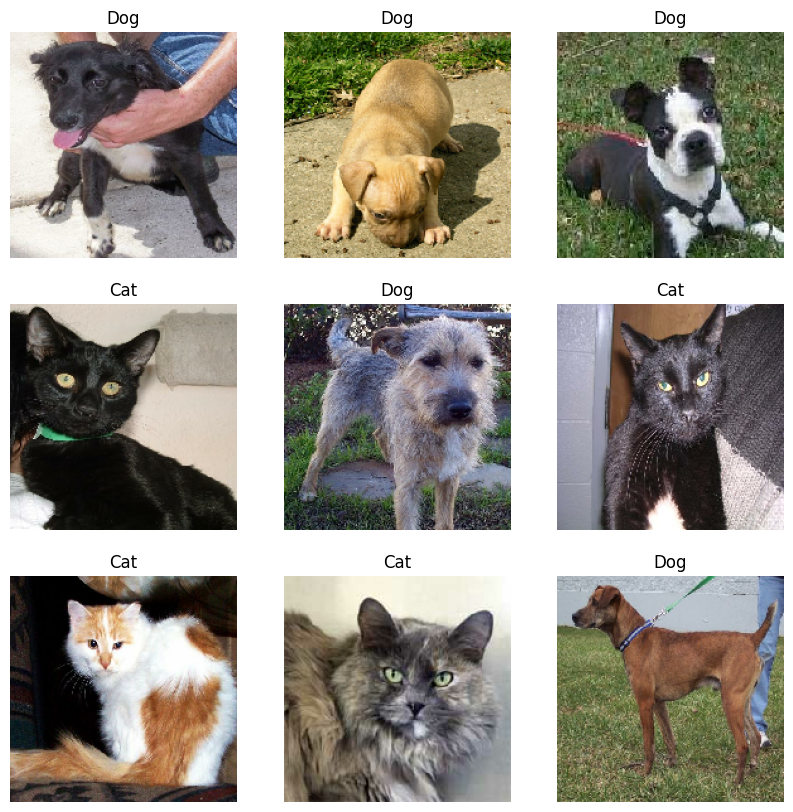

In [23]:
import matplotlib.pyplot as plt

for image_batch, label_batch in high_performance_train_ds.take(1):

  plt.figure(figsize=(10,10))
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint32"))
    label = label_batch[i]
    plt.title(labels[label])
    plt.axis("off")

In [22]:
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(180,180,3))

In [23]:
base_model.trainable = False

In [24]:
flatten_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(100, activation='relu')
dropout_layer = tf.keras.layers.Dropout(0.5)
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [25]:
model = tf.keras.models.Sequential([
  base_model,
  flatten_layer,
  dense_layer,
  dropout_layer,
  prediction_layer
])

In [26]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss = tf.keras.losses.BinaryCrossentropy, metrics=['acc'])

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,766,089 (56.33 MB)

 Trainable params: 51,401 (200.79 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model.fit(high_performance_train_ds, epochs=100, validation_data=high_performance_validation_ds)

Epoch 1/100
    619/Unknown 107s 147ms/step - acc: 0.8893 - loss: 0.7199

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


619/619 ━━━━━━━━━━━━━━━━━━━━ 131s 185ms/step - acc: 0.8894 - loss: 0.7192 - val_acc: 0.9598 - val_loss: 0.1151
Epoch 2/100
288/619 ━━━━━━━━━━━━━━━━━━━━ 48s 146ms/step - acc: 0.9493 - loss: 0.1473